In [1]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests
import fiona
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Background

- The code in this notebook was originally used to come up with a method ("land area spatial overlap") to distribute the American Community Survey (ACS) data from the Census Tract level to the Election District level in NYC. The land area spatial overlap method calculates how much one geographical area shares boundaries with another geographical area.
- The ACS information at the election districts can be used to understand what poll sites (made up of a combination of election districts), for example, will benefit most from language interpretation services (data on limited English proficiency (LEP) is one of the variables in the ACS data).
- While this method does not take into account the population density of an area in proportioning data from one area to another, it is still a highly useful and relevant method, especially when the data on population density does not exist or if the geographical areas roughly follow the same population density distribution.
- The code below uses open datasets to demonstrate an open source solution of this method. It can be used to apportion data between any geographic levels. 

### 1. Import Election Districts Data and Census Tracts Data (as of Decennial Census 2010) from the NYC Open Data Portal.

[Election Districts](https://data.cityofnewyork.us/City-Government/Election-Districts/h2n3-98hq): The geographical area used by the NY State Board of Elections to determine placement of poll sites. There are 5,840 election districts that roll up to over 1,000 poll sites in Primary and General election periods in NYC.

[Census Tracts](https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku): The census tracts are small, permanent geographical unit of a county or its geographical equivalent. According to the Census Bureau, the number of people that reside in a census tract is between 1,200 and 8,000. There are 2,175 census tracts in NYC. 

Analyzing data for smaller geographies can allow for better analysis and census tracts tend to be great in that sense. However, their results should be interpreted with caution when using ACS estimates due to its small sample size.

Variables of interest:
- boro_code: A code associated with each of the five boroughs. (Manhattan = 1, Bronx=2, Brooklyn=3, Queens=4, Staten Island=5)
- boro_ct2010: a unique identifier for each census tract number given that a census tract number may not be unique.
- boro_name: name of one of the five boroughs of NYC
- ct2010: census tract number
- ctlabel: truncated census tract number

### 1.1. Import Election Districts Shapefile (clipped to the shore) from NYC Open Data.  *Source: Decennial Census 2010*

In [2]:
def import_shapefile_and_area_in_sqkm(four_by_four_code):
    '''
    Import a shapefile and calculate the area in square kilometer for each tile. 
    
    Input:
        - four_by_four_code: a string that contains 8 alphanumeric letters assigned 
           to each open dataset on NYC Open Data Portal.
    
    Returns:
        - a geopandas dataframe.
    
    '''
    
    # import the shapefile as GeoJSON from the open data portal
    request = requests.get("https://data.cityofnewyork.us/api/geospatial/" + \
                           four_by_four_code + "?method=export&format=GeoJSON")
    
    visz = fiona.ogrext.buffer_to_virtual_file(bytes(request.content))
    
    # read the features from a fiona collection into a GeoDataFrame
    with fiona.Collection(visz, driver='GeoJSON') as f:
        nyc_opendata_gpd = geopandas.GeoDataFrame.from_features(f, crs=f.crs)
    
    print("coordinate reference system of the shapefile: ", nyc_opendata_gpd.crs)
    
    # convert the geometry into an equal projection area, and then meter square into kilometer square

    # source: https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
    nyc_opendata_gpd['area_in_sqkm'] = nyc_opendata_gpd['geometry'].to_crs({'init': 'epsg:3395'})\
                   .map(lambda p: p.area / 10**6)
    
    return nyc_opendata_gpd

In [3]:
ed_nyc_od_gpd = import_shapefile_and_area_in_sqkm("h2n3-98hq")

coordinate reference system of the shapefile:  {'init': 'epsg:4326'}


In [4]:
ed_nyc_od_gpd.head()

,elect_dist,geometry,shape_area,shape_leng,area_in_sqkm
0,23001,(POLYGON ((-73.92036810280452 40.5622188324676...,26047167.3768,25487.7493389,4.180
1,23002,(POLYGON ((-73.91499674408279 40.5622503371911...,5646613.50195,13511.9501208,0.906
2,23003,(POLYGON ((-73.88346534749658 40.5684780199384...,25256925.1875,42505.973957,4.054
3,23004,(POLYGON ((-73.86522555434863 40.5704584724939...,15164800.0938,27487.6510104,2.435
4,23005,(POLYGON ((-73.85726388403346 40.5698013951326...,6156202.00394,16269.6435779,0.988


In [5]:
# number of unique ED's
ed_nyc_od_gpd['elect_dist'].nunique()

5840

Plot the map.

Text(0.5, 1, 'Election Districts of NYC as of June 2021')

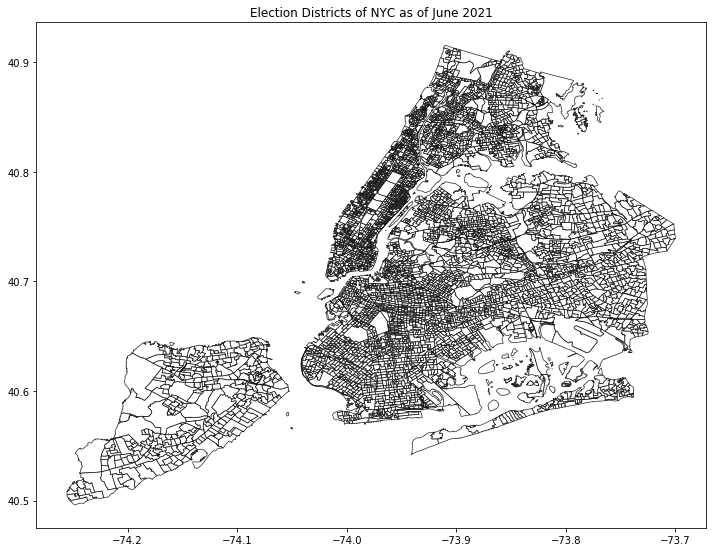

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal')

ed_nyc_od_gpd.plot(ax=ax, color='white', edgecolor='black', linewidth=0.75, alpha=0.8)

plt.title("Election Districts of NYC as of June 2021")

### 1.2. Import Census Tracts Shapefile from NYC Open Data. *Source: Decennial Census 2010*

In [7]:
census_tracts_2010_gpd = import_shapefile_and_area_in_sqkm("fxpq-c8ku")

coordinate reference system of the shapefile:  {'init': 'epsg:4326'}


In [8]:
census_tracts_2010_gpd.head()

,boro_code,boro_ct2010,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,area_in_sqkm
0,5,5000900,Staten Island,E,000900,9,(POLYGON ((-74.07920577013245 40.6434307837456...,SI22,West New Brighton-New Brighton-St. George,3903,2497009.69813,7729.01679376,0.402
1,1,1009800,Manhattan,I,009800,98,(POLYGON ((-73.96432543478758 40.7563815309909...,MN19,Turtle Bay-East Midtown,3808,1906016.37104,5534.20005771,0.308
2,1,1010200,Manhattan,I,010200,102,(POLYGON ((-73.97124277307127 40.7609364184790...,MN17,Midtown-Midtown South,3807,1860992.70485,5687.80243866,0.300
3,1,1010400,Manhattan,I,010400,104,(POLYGON ((-73.97445730550224 40.7622930835248...,MN17,Midtown-Midtown South,3807,1864600.37503,5693.03636655,0.301
4,1,1011300,Manhattan,I,011300,113,(POLYGON ((-73.98411754823195 40.7548420534646...,MN17,Midtown-Midtown South,3807,1890907.3117,5699.86071223,0.305


Plot the map.

Text(0.5, 1, 'Census Tracts of NYC - Decennial Census 2010')

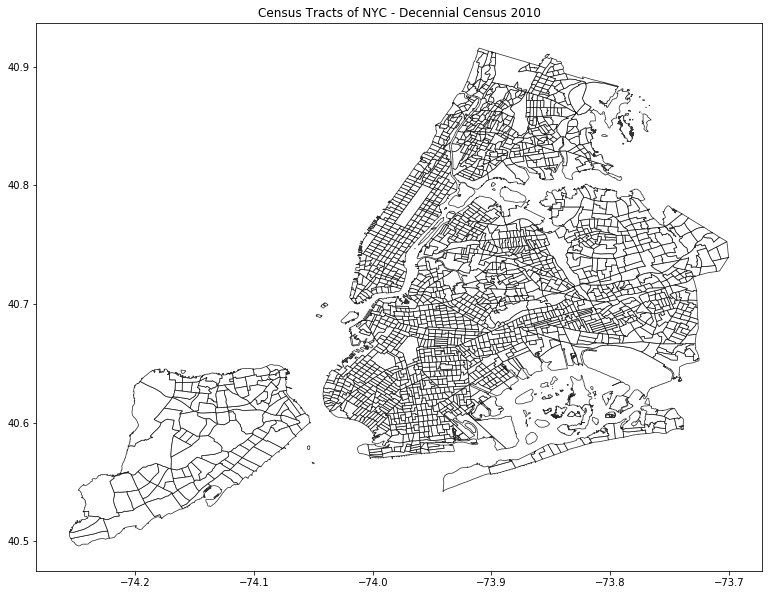

In [9]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.set_aspect('equal')
census_tracts_2010_gpd.plot(ax=ax, color='white', edgecolor='black', linewidth=0.75, alpha=0.8)
plt.title("Census Tracts of NYC - Decennial Census 2010")

In [10]:
census_tracts_2010_gpd.crs

{'init': 'epsg:4326'}

In [11]:
census_tracts_2010_gpd.shape

(2165, 13)

### 2. *Overlay* both Election Districts and Census Tracts shapefiles

From Geopandas [documentation](https://geopandas.org/gallery/overlays.html) on overlaying geographical areas:

"Spatial overlays allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new GeoDataFrame with the new geometries representing the spatial combination and merged properties."

In [12]:
eds_to_tracts_intersection = geopandas.overlay(ed_nyc_od_gpd, census_tracts_2010_gpd, how='intersection')

In [13]:
eds_to_tracts_intersection.head(5)

,elect_dist,shape_area_1,shape_leng_1,area_in_sqkm_1,boro_code,boro_ct2010,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area_2,shape_leng_2,area_in_sqkm_2,geometry
0,23001,26047167.3768,25487.7493389,4.180,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,"POLYGON ((-73.92036810280452 40.5622188324676,..."
1,23002,5646613.50195,13511.9501208,0.906,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,POLYGON ((-73.91499674408279 40.56225033719116...
4,23003,25256925.1875,42505.973957,4.054,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,POLYGON ((-73.88346534749658 40.56847801993845...
8,23004,15164800.0938,27487.6510104,2.435,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,(POLYGON ((-73.88276986199288 40.5675974213716...
2,23003,25256925.1875,42505.973957,4.054,4,4091602,Queens,I,091602,916.02,QN99,park-cemetery-etc-Queens,4114,13689757.8646,17640.8015086,2.197,(POLYGON ((-73.88957035234063 40.5656904266095...


Text(0.5, 1, 'Map of Election Districts (green border) and Census Tracts (white border) Overlapped')

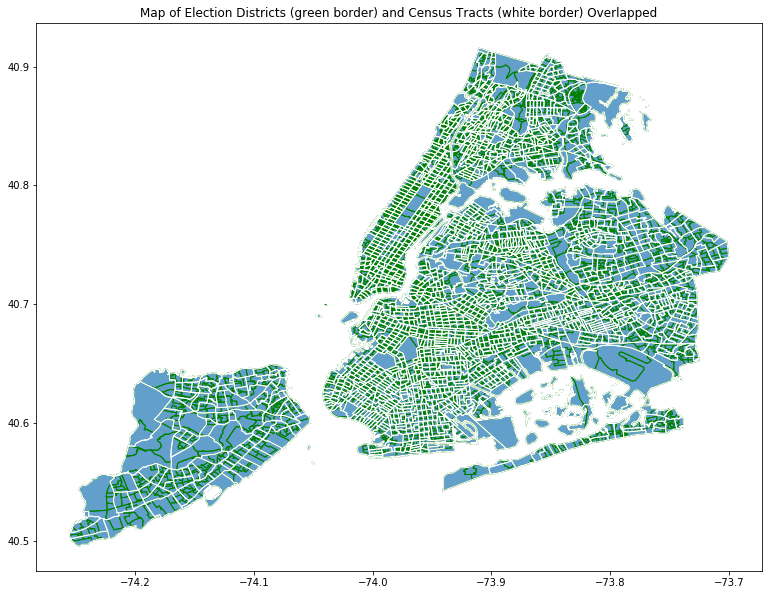

In [14]:
ax = eds_to_tracts_intersection.plot(alpha=0.7, figsize=(13, 13))

ed_nyc_od_gpd.plot(ax=ax, facecolor='none', edgecolor='g')
census_tracts_2010_gpd.plot(ax=ax, facecolor='none', edgecolor='w')

plt.title("Map of Election Districts (green border) and Census Tracts (white border) Overlapped")

If there were any areas that were not filled with blue color, that would indicate that there's no overlapping boundaries between census tracts and election districts.

### 3. After overlaying, calculate the intersection area into square km and identify the census tract-to-election district ratio (i.e. percentage of census tract that shares boundaries with an election district)

In [15]:
# calculate intersection area into square km
eds_to_tracts_intersection['intersection_sqkm'] = \
                eds_to_tracts_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: p.area / 10**6)

In [16]:
eds_to_tracts_intersection.head()

,elect_dist,shape_area_1,shape_leng_1,area_in_sqkm_1,boro_code,boro_ct2010,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area_2,shape_leng_2,area_in_sqkm_2,geometry,intersection_sqkm
0,23001,26047167.3768,25487.7493389,4.180,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,"POLYGON ((-73.92036810280452 40.5622188324676,...",4.180
1,23002,5646613.50195,13511.9501208,0.906,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,POLYGON ((-73.91499674408279 40.56225033719116...,0.906
4,23003,25256925.1875,42505.973957,4.054,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,POLYGON ((-73.88346534749658 40.56847801993845...,2.362
8,23004,15164800.0938,27487.6510104,2.435,4,4091601,Queens,I,091601,916.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,46959894.1041,48384.3908336,7.536,(POLYGON ((-73.88276986199288 40.5675974213716...,0.088
2,23003,25256925.1875,42505.973957,4.054,4,4091602,Queens,I,091602,916.02,QN99,park-cemetery-etc-Queens,4114,13689757.8646,17640.8015086,2.197,(POLYGON ((-73.88957035234063 40.5656904266095...,1.692


Add two metrics to show a) the proportion of a single ED that falls in a census tract and b) the proportion of a single census tract that is occupied by the census tract.

In [17]:
eds_to_tracts_intersection['elect_dist_area_percent_of_tract_km'] = \
    eds_to_tracts_intersection['intersection_sqkm']/eds_to_tracts_intersection['area_in_sqkm_2']

eds_to_tracts_intersection['elect_dist_area_percent_as_a_whole_km'] = \
    eds_to_tracts_intersection['intersection_sqkm']/eds_to_tracts_intersection['area_in_sqkm_1']

Rearrange the order of the dataframe by borough, census tract and the election district.

In [18]:
eds_to_tracts_intersection_groupby = eds_to_tracts_intersection.dissolve(
    by=['boro_name', 'boro_ct2010', 'ct2010', 'elect_dist'],
    aggfunc='sum'
    ).reset_index()

In [19]:
eds_to_tracts_intersection_groupby.shape

(16602, 10)

In [20]:
eds_to_tracts_intersection_groupby.head()

,boro_name,boro_ct2010,ct2010,elect_dist,geometry,area_in_sqkm_1,area_in_sqkm_2,intersection_sqkm,elect_dist_area_percent_of_tract_km,elect_dist_area_percent_as_a_whole_km
0,Bronx,2000100,000100,85035,POLYGON ((-73.88639344506386 40.79786125541467...,2.933,2.936,2.933,0.999,1.000
1,Bronx,2000100,000100,85079,(POLYGON ((-73.88885148496418 40.7987063284561...,0.002,2.936,0.002,0.001,1.000
2,Bronx,2000200,000200,85002,POLYGON ((-73.85561851117899 40.81060771695554...,0.520,0.810,0.399,0.492,0.767
3,Bronx,2000200,000200,85003,(POLYGON ((-73.85483797983032 40.8073705926731...,0.271,0.810,0.000,0.000,0.000
4,Bronx,2000200,000200,85004,(POLYGON ((-73.85772069876592 40.8133624076961...,0.603,0.810,0.003,0.004,0.005


Perform a quick QA to check that the proportions of a all ED's sum up to 1 (i.e. 100%). If it does, then it shows that all the ED's of NYC are completely mapped to one or more census tracts

In [21]:
election_district_proportions_QA = eds_to_tracts_intersection_groupby\
    .groupby(['elect_dist'])['elect_dist_area_percent_as_a_whole_km'].sum().reset_index()\
    .sort_values('elect_dist_area_percent_as_a_whole_km', ascending=True)

In [22]:
election_district_proportions_QA.head()

,elect_dist,elect_dist_area_percent_as_a_whole_km
1217,37070,1.000
1056,35057,1.000
1057,35058,1.000
1135,36071,1.000
1058,35059,1.000


In [23]:
# subtracting 0.01 from the lower bound and adding 0.01 to upper bound to account for rounding issues in "elect_dist_area_percent_as_a_whole_km"
election_district_proportions_QA[(election_district_proportions_QA['elect_dist_area_percent_as_a_whole_km'] < 0.99) | \
                                 (election_district_proportions_QA['elect_dist_area_percent_as_a_whole_km'] > 1.01)]

,elect_dist,elect_dist_area_percent_as_a_whole_km


Given the search results are empty, it shows that all election districts were able to map completely to the census tracts.

### 4. Demo: Plot the intersection areas of sample neighborhood to show how the data can be distributed to a different geographic level

Prospect Heights is a neighborhood in central Brooklyn

In [24]:
prospect_heights_ed = ed_nyc_od_gpd[ed_nyc_od_gpd['elect_dist'].isin(['57063', '57071'])]
prospect_heights_census_tracts = census_tracts_2010_gpd[census_tracts_2010_gpd['ntaname'] == 'Prospect Heights']

#intersect the two election districts with census tracts of Prospect Heights
prospect_heights_ed_and_tracts_intersection = geopandas.overlay(prospect_heights_ed, \
                                                                prospect_heights_census_tracts, how='intersection')

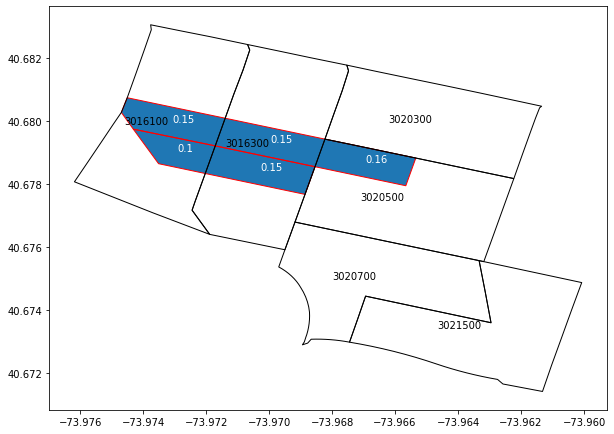

In [26]:
ax = prospect_heights_ed_and_tracts_intersection.plot(figsize=(10, 10))

# plot the ED's and census tracts of Prospect Heights
prospect_heights_ed.plot(ax=ax, facecolor='none', edgecolor='r');
# prospect_heights_ed.apply(lambda x: ax.annotate(s=x['elect_dist'], \
#                 xy=x.geometry.centroid.coords[0], ha='center', color='w'),axis=1);

prospect_heights_census_tracts.plot(ax=ax, facecolor='none', edgecolor='k');

prospect_heights_census_tracts.apply(lambda x: ax.annotate(s=x['boro_ct2010'], \
        xy=x.geometry.centroid.coords[0], ha='right'),axis=1);

# Calculate the intersection area of election districts and census tracts in square kilometer
prospect_heights_ed_and_tracts_intersection['intersection_sqkm'] = \
        prospect_heights_ed_and_tracts_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
       .map(lambda p: p.area / 10**6)

# calculate the metrics that show proportion of each election district and census tract 
prospect_heights_ed_and_tracts_intersection['elect_dist_area_percent_of_tract_km'] = \
        prospect_heights_ed_and_tracts_intersection['intersection_sqkm']/\
        prospect_heights_ed_and_tracts_intersection['area_in_sqkm_2']

prospect_heights_ed_and_tracts_intersection['elect_dist_area_percent_as_a_whole_km'] = \
        prospect_heights_ed_and_tracts_intersection['intersection_sqkm']/\
        prospect_heights_ed_and_tracts_intersection['area_in_sqkm_1']

#annonate the first metric i.e. "what percent of census tract is occupied by the election district?" on the map
prospect_heights_ed_and_tracts_intersection.apply(\
                lambda x: ax.annotate(s=round(x['elect_dist_area_percent_of_tract_km'], 2),\
                xy=x.geometry.centroid.coords[0], ha='left', color='w'),axis=1);

The visualization above is of only two election districts (the horizontal election district above, 57063, and the one below, 57071) in Prospect Heights. In order to apportion the data from the Census Tract 3016300 to the above horizontal election district, we'll multiply the data by 0.15. That is the share of the census tract given to that election district.

E.g. If there are 1,500 residents who speak Russian in Census Tract 3016300, then the number of Russian speakers in the Election District 57063 will be 225.